# Fit Convergent Cross Mapping Model to Data Sets

In this file, it includes two main parts which are fitting CCM based on State wise and Country wise. Also, there are three models respectively:
1. Alcohol establishments against total rape
2. Alcohol establishments against shifted total rape
3. Alcohol establishments against misogyny tweets

In [1]:
import pandas as pd
import numpy as np
import skccm as ccm
import matplotlib.pyplot as plt
import seaborn as sns
from skccm.utilities import train_test_split
from teaspoon.parameter_selection.FNN_n import FNN_n

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# from 2012-2020 9 years in total, 12 months for each year
merged_data = pd.read_csv('./data/merged_data.csv',index_col=0)
merged_data = merged_data.sort_values(by=['year','month'],ascending=[True, True])

In [3]:
merged_data.head()

,USstate,year,month,nTweets_x,nTweets_y,Number of establishments (ESTAB),abbr,full,population,actual_rape_total,cost_of_living_index
0,al,2012,1,51744.000000,3.00,367.0,al,Alabama,4834334,106,71.180000
108,ak,2012,1,20125.600000,1.35,101.0,ak,Alaska,735190,39,77.304376
216,az,2012,1,57016.090909,1.00,208.0,az,Arizona,6572455,205,92.889410
324,ar,2012,1,7733.000000,1.00,318.0,ar,Arkansas,2981157,108,66.683538
432,ca,2012,1,134228.000000,5.00,3733.0,ca,California,38183375,671,65.724957


# Part A: State-wise

In [4]:
state_list = list(set(merged_data['USstate'].to_list()))
print(len(state_list))

43


## 1. Quick View

### i). Total Rape Crime

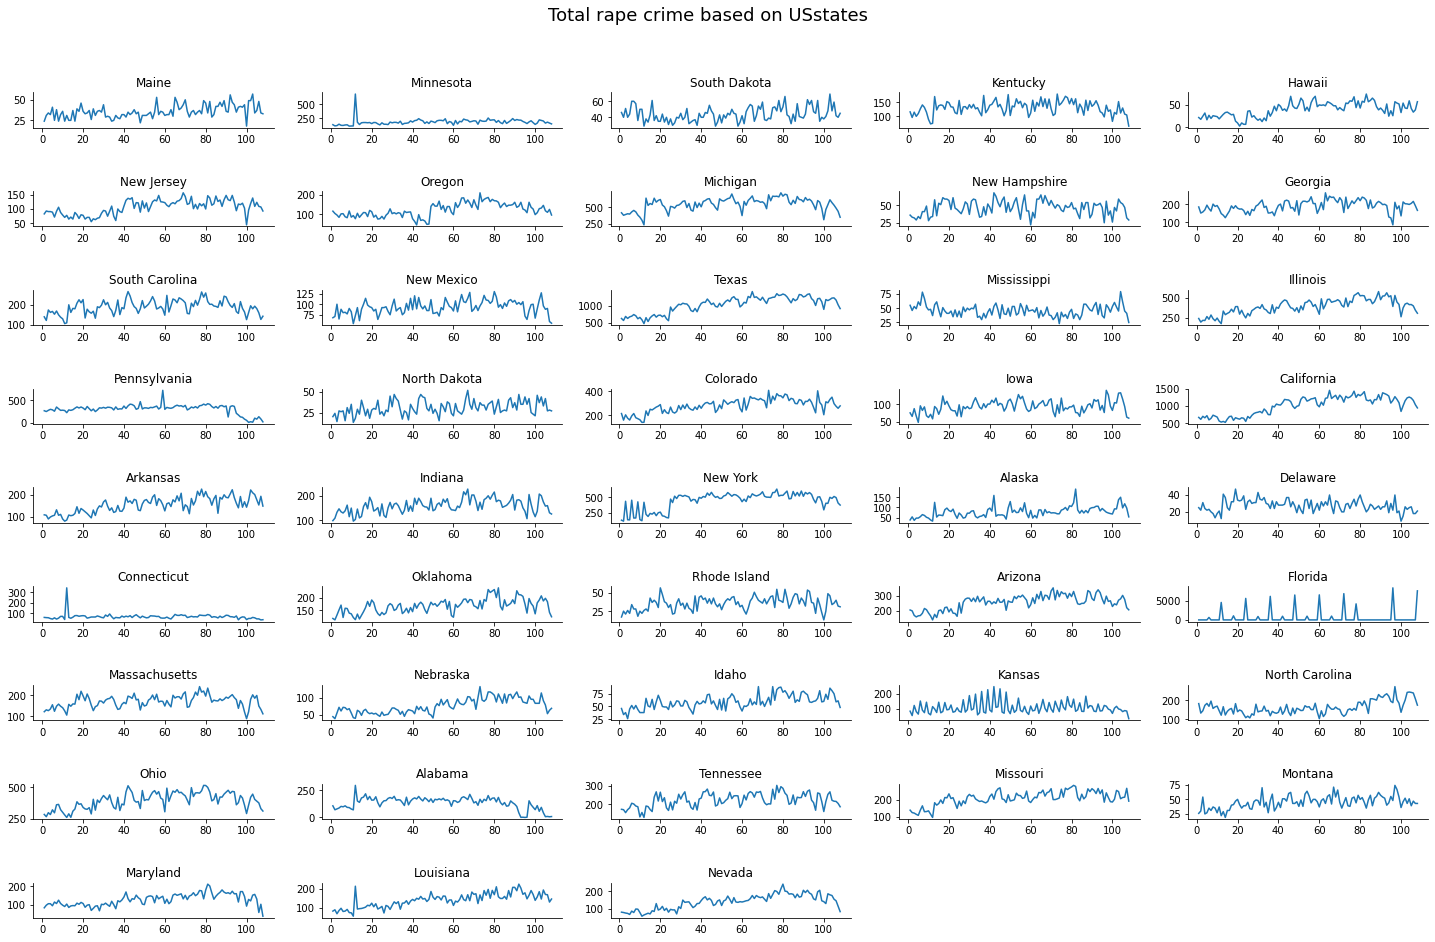

In [11]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Total rape crime based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()

    x1_rape_total = data['actual_rape_total'].to_numpy()

    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(np.arange(1,109),x1_rape_total)
    ax.set_title(curr_state)
    sns.despine()
    
plt.savefig('./figures/Total rape crime based on USstates.png')

### ii). Shifted Rape Crime

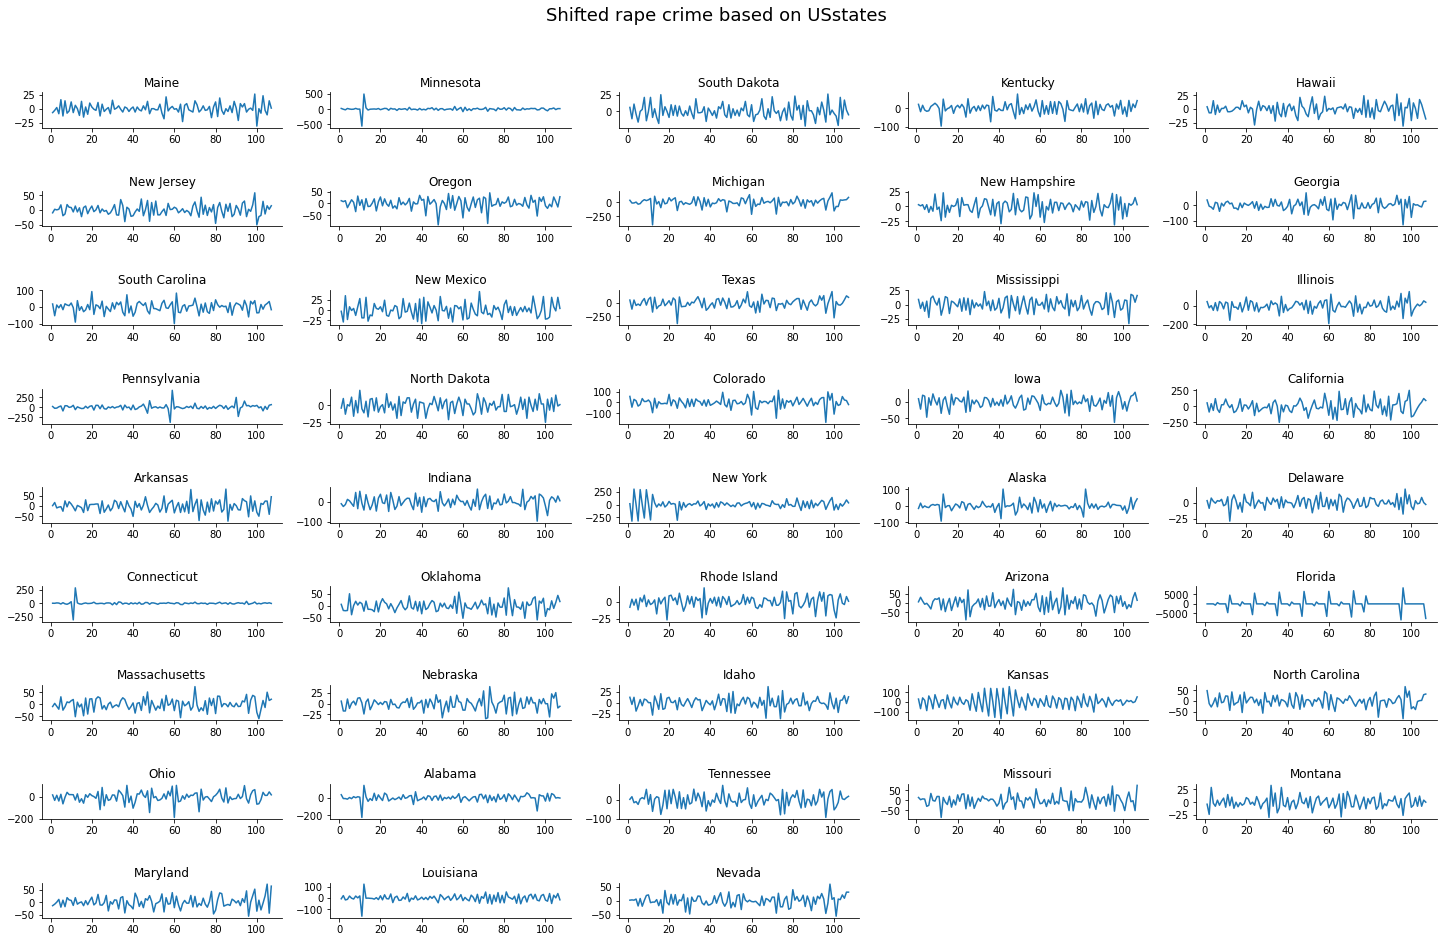

In [12]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Shifted rape crime based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['shifted_rape_total'] = data['actual_rape_total'] - data['actual_rape_total'].shift(-1)

    x1_shifted_rape_total = data['shifted_rape_total'].to_numpy()

    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(np.arange(1,109),x1_shifted_rape_total)
    ax.set_title(curr_state)
    sns.despine()
    
plt.savefig('./figures/Shifted rape crime based on USstates.png')

### iii). Misogyny tweets

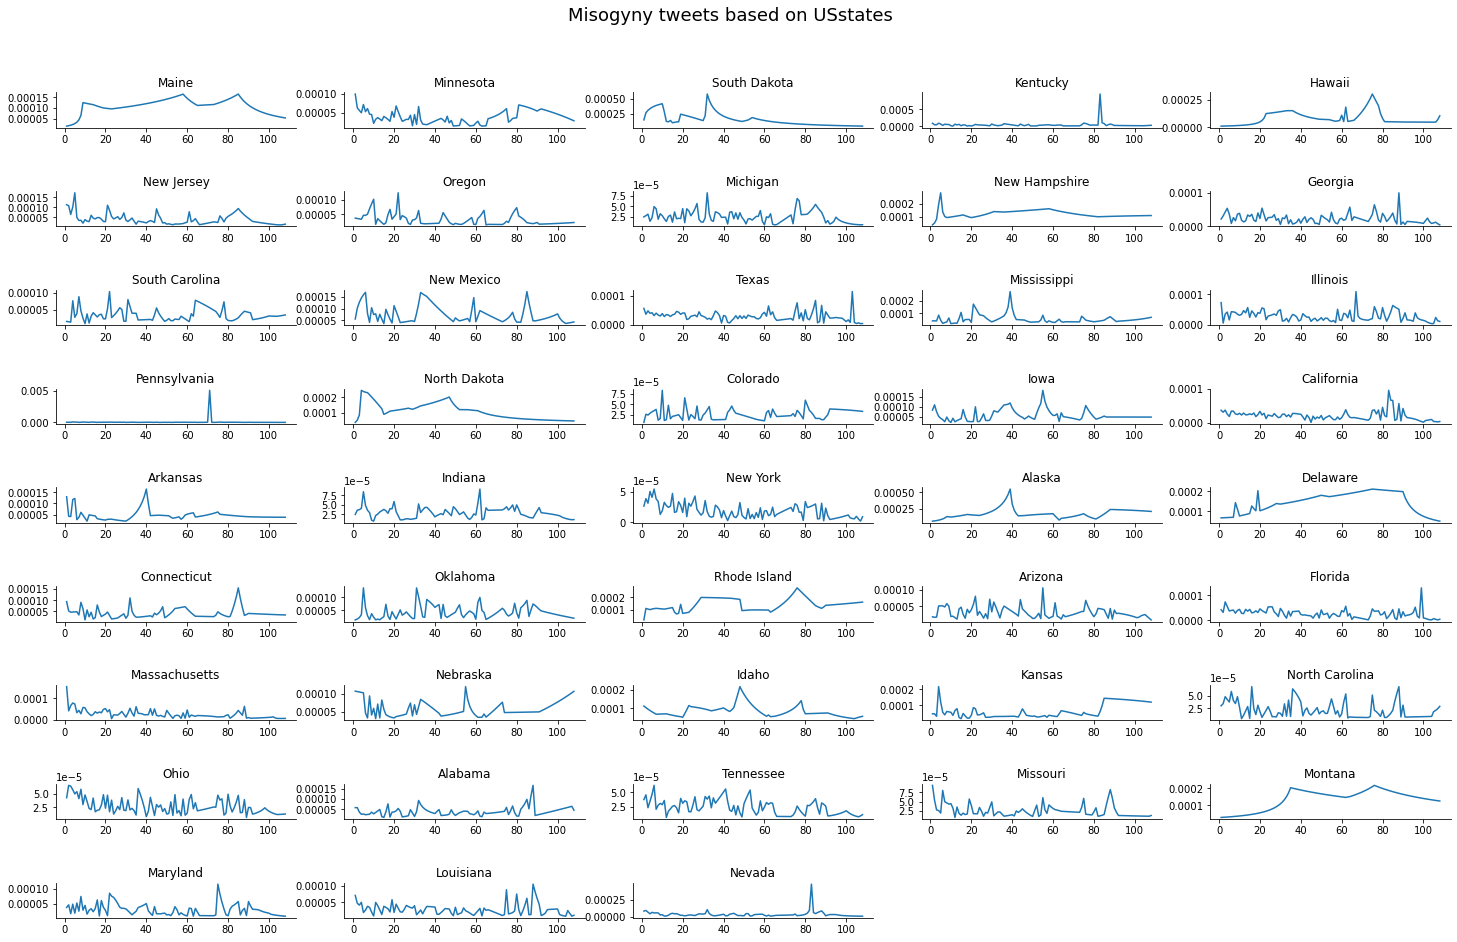

In [13]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Misogyny tweets based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    
    x2_misogyny_proportion = data['misogyny_proportion'].to_numpy()
    

    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(np.arange(1,109),x2_misogyny_proportion)
    ax.set_title(curr_state)
    sns.despine()
    
plt.savefig('./figures/Misogyny tweets based on USstate.png')

### iv). Alcohol Establishments

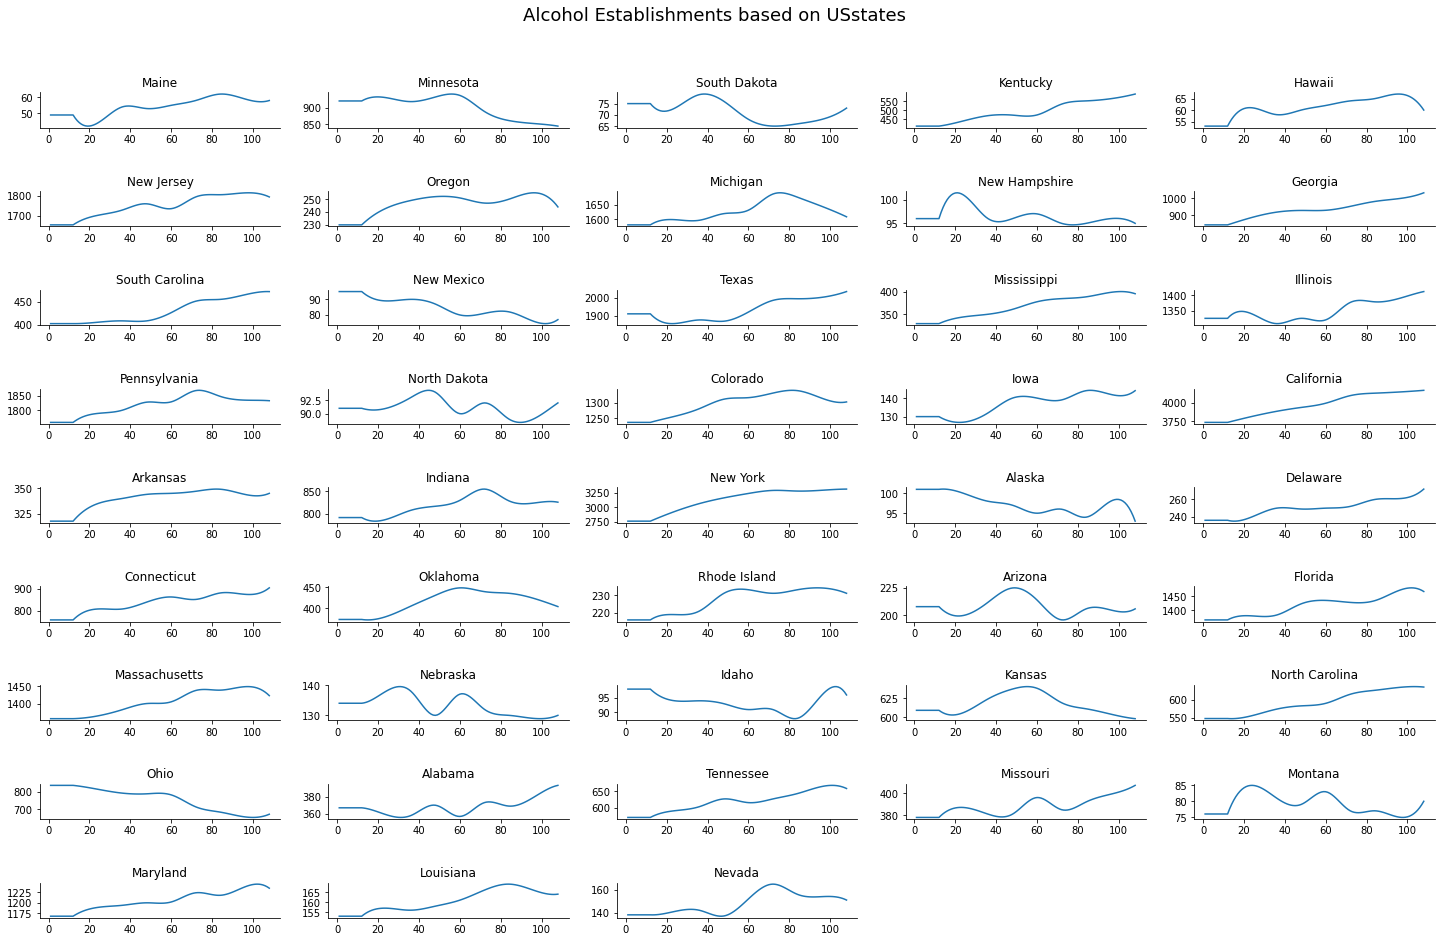

In [14]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Alcohol Establishments based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    
    x3_alcohol = data['Number of establishments (ESTAB)'].to_numpy()
    

    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(np.arange(1,109),x3_alcohol)
    ax.set_title(curr_state)
    sns.despine()

plt.savefig('./figures/Alcohol Establishments based on USstates.png')

### v). Shifted Alcohol Establishments

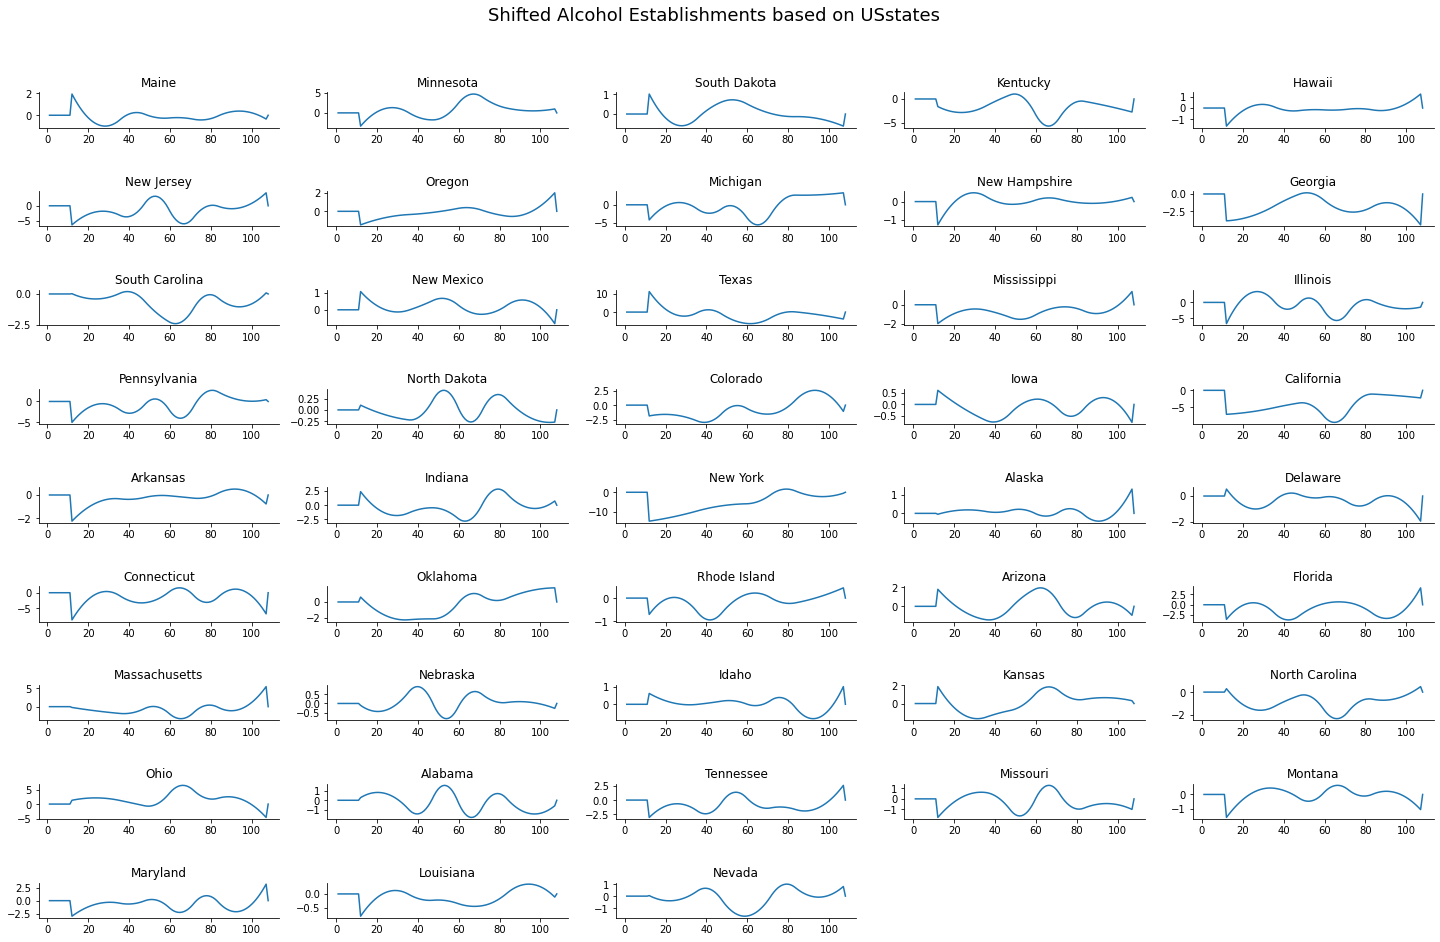

In [15]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Shifted Alcohol Establishments based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['shifted_alcohol'] = data['Number of establishments (ESTAB)'] - data['Number of establishments (ESTAB)'].shift(-1)
    data['shifted_alcohol'] = data['shifted_alcohol'].fillna(0)
    
    x3_alcohol = data['shifted_alcohol'].to_numpy()
    

    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(np.arange(1,109),x3_alcohol)
    ax.set_title(curr_state)
    sns.despine()
    
plt.savefig('./figures/Shifted Alcohol Establishments based on USstates.png')

## 2. Fit CCM

### i). Alcohol vs Crime

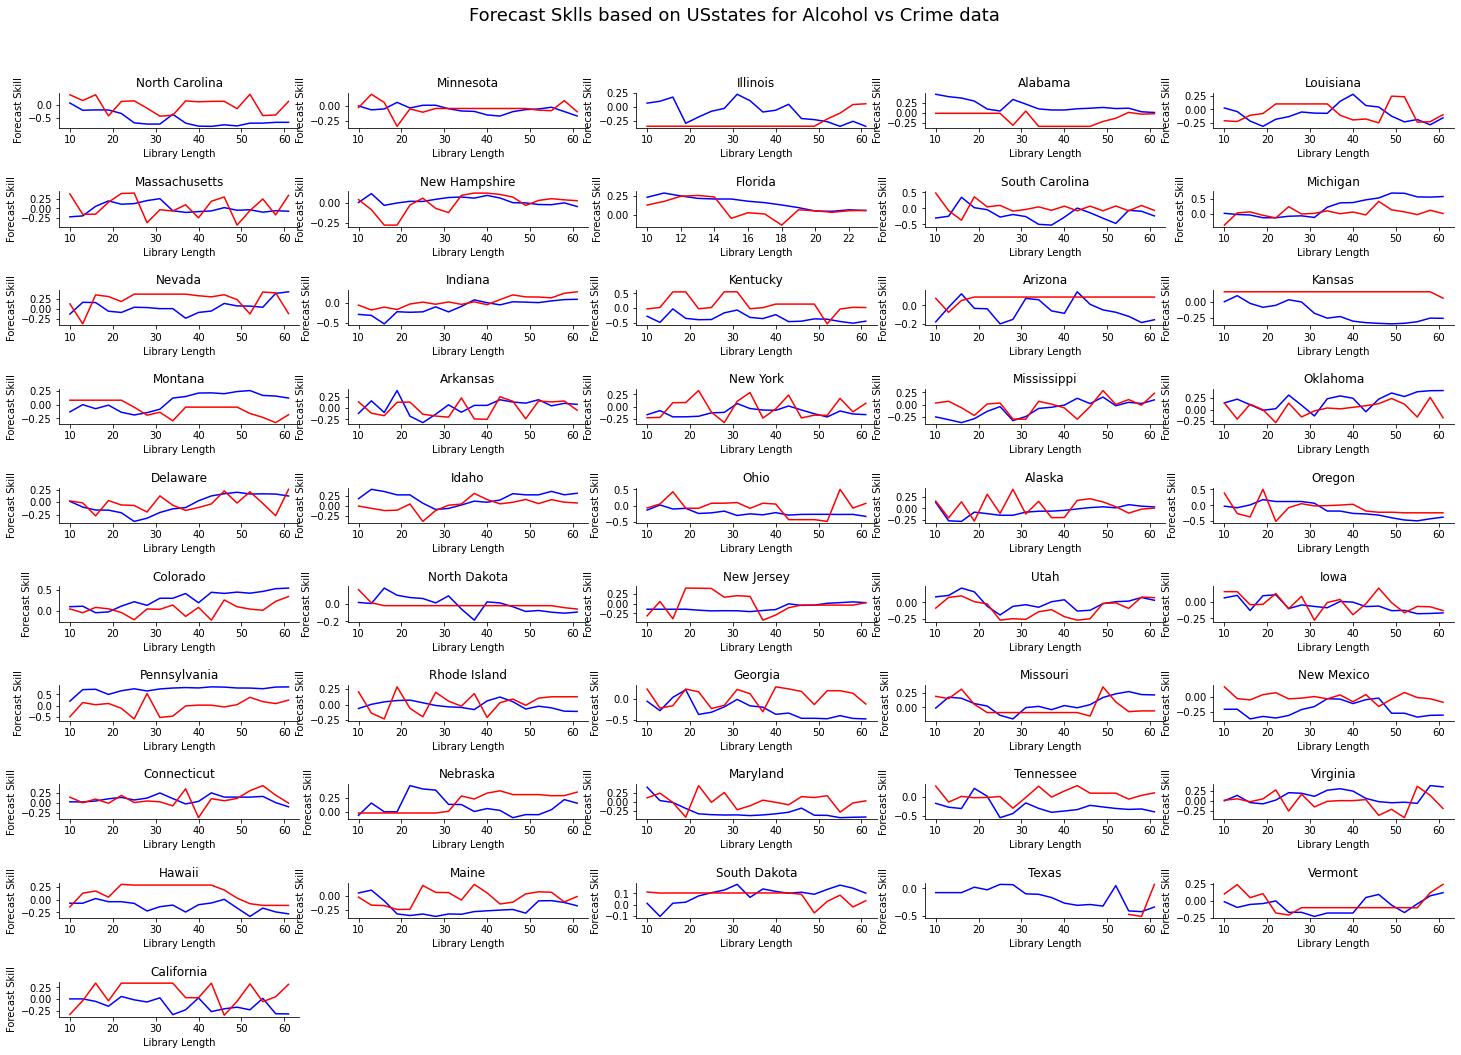

In [236]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Sklls based on USstates for Alcohol vs Crime data", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    
    # 0. extract data
    x1_alcohol = data['Number of establishments (ESTAB)'].to_numpy()
    x2_crime = data['actual_rape_total'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_alcohol)
    e2 = ccm.Embed(x2_crime)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_crime, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # alcohol predict crime
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict alcohol
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

### ii). Shifted Alcohol vs Shifted Crime

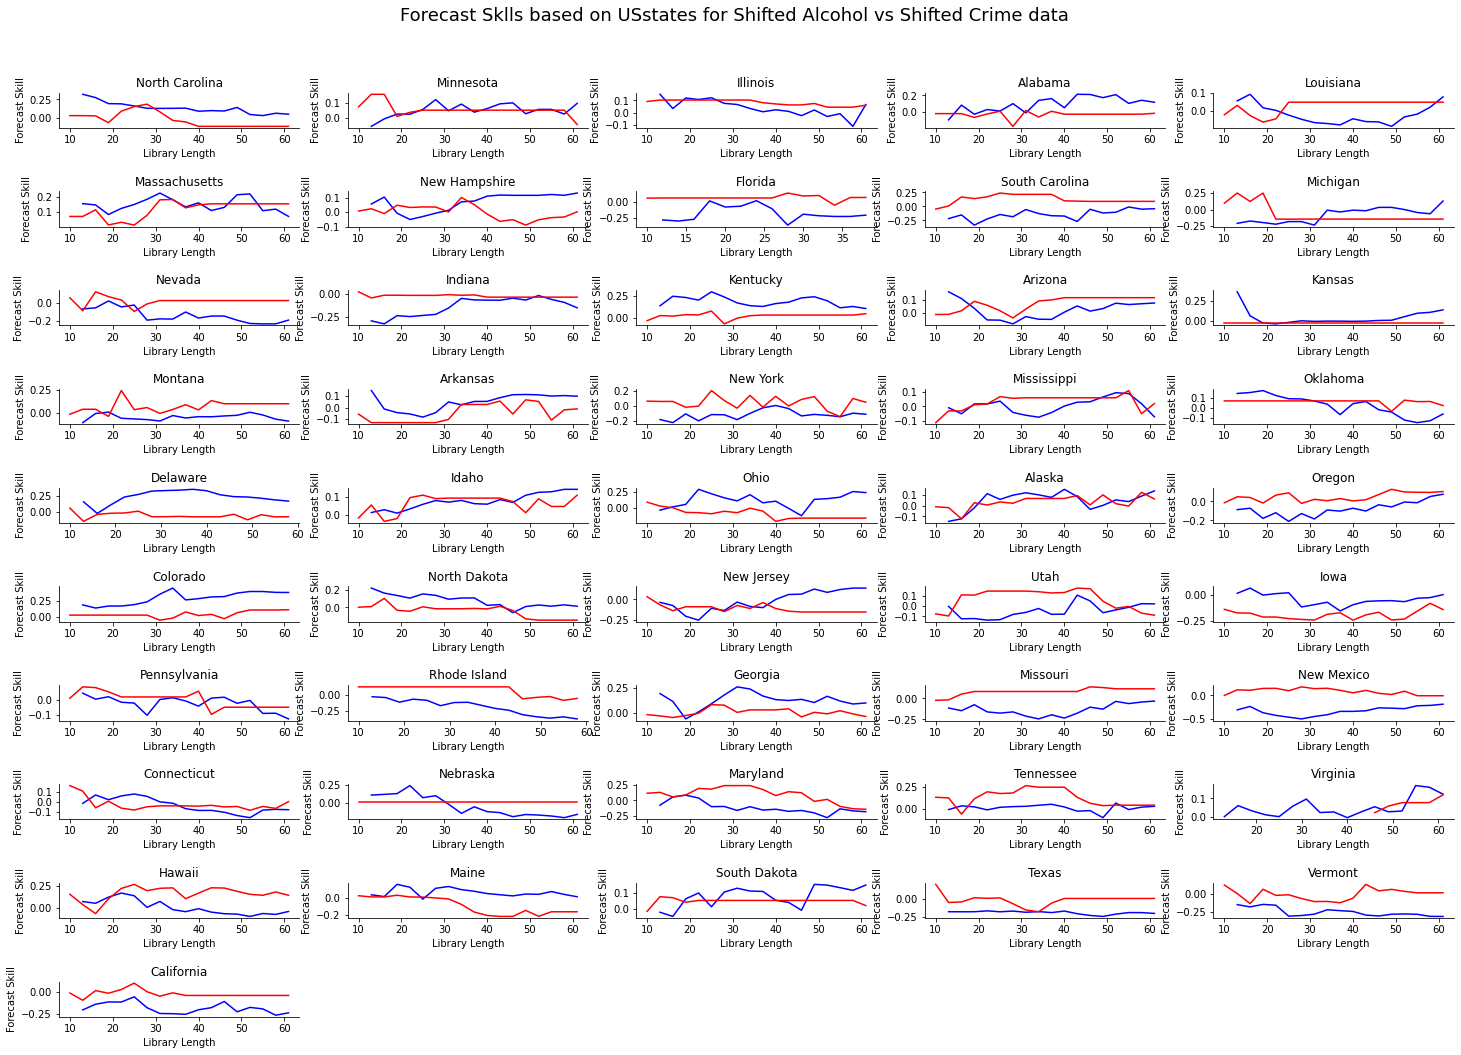

In [316]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Sklls based on USstates for Shifted Alcohol vs Shifted Crime data", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['shifted_rape_total'] = data['actual_rape_total'] - data['actual_rape_total'].shift(-1)
    data['shifted_rape_total'] = data['shifted_rape_total'].fillna(0)
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    data['shifted_alcohol'] = data['Number of establishments (ESTAB)'] - data['Number of establishments (ESTAB)'].shift(-1)
    data['shifted_alcohol'] = data['shifted_alcohol'].fillna(0)
    
    # 0. extract data
    x1_alcohol = data['shifted_alcohol'].to_numpy()
    x2_rape_total = data['shifted_rape_total'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_alcohol)
    e2 = ccm.Embed(x2_rape_total)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_rape_total, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # shifted alcohol predict shifted crime
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # shifted crime predict shifted alcohol
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

### iii). Shifted Alcohol vs Tweets

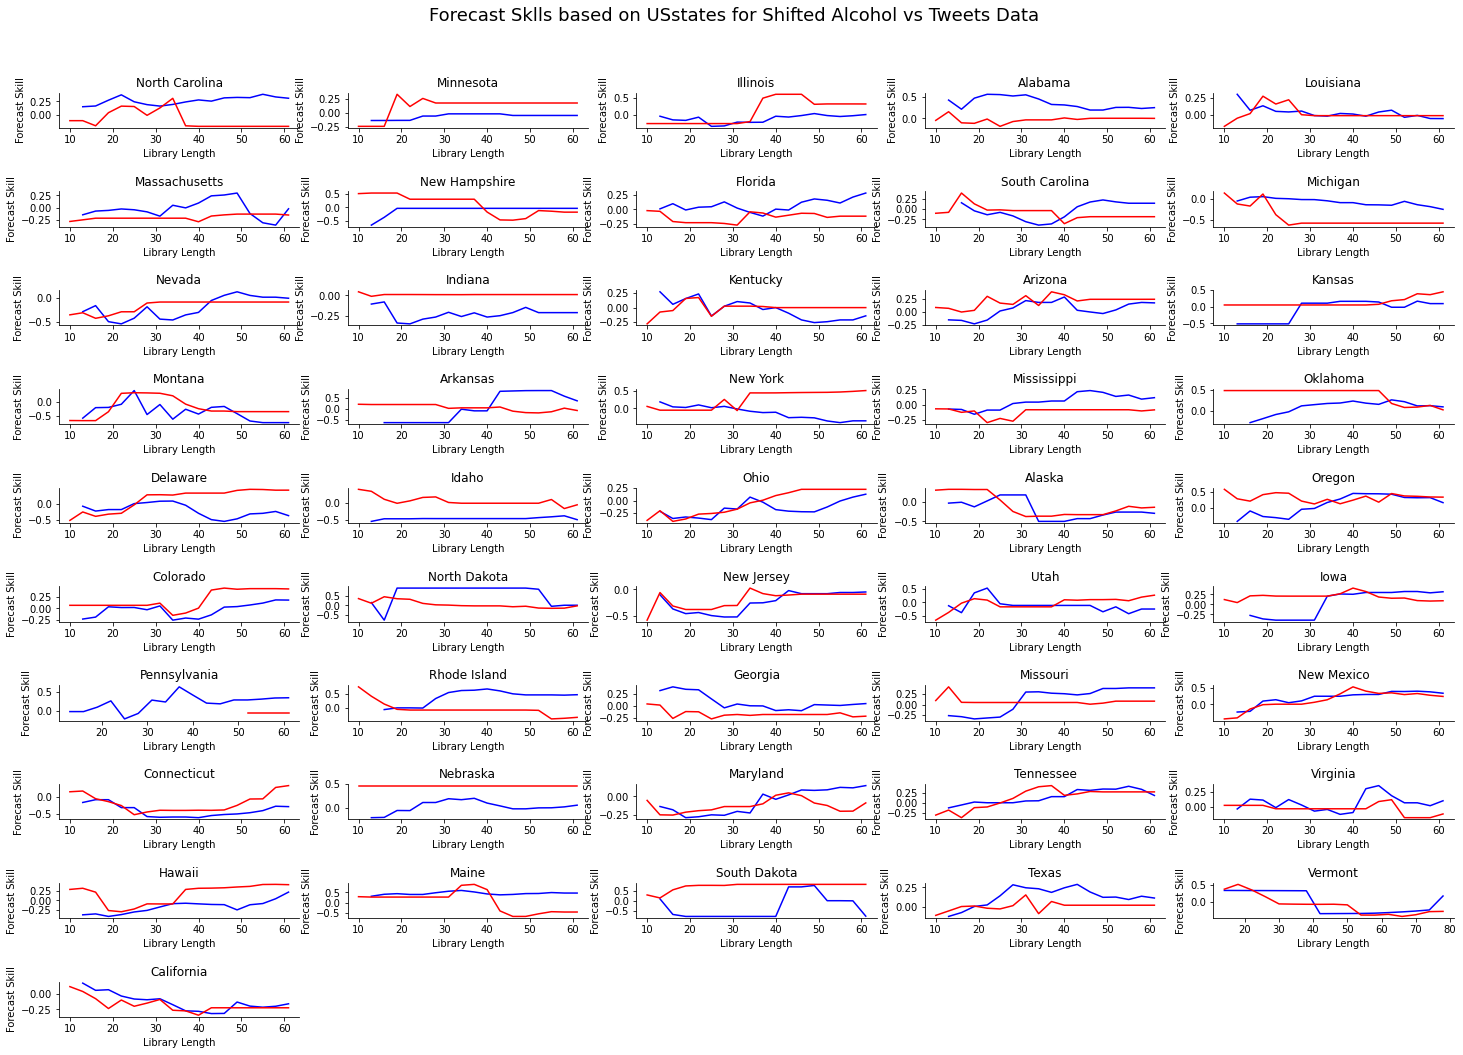

In [317]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Sklls based on USstates for Shifted Alcohol vs Tweets Data", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    data['shifted_alcohol'] = data['Number of establishments (ESTAB)'] - data['Number of establishments (ESTAB)'].shift(-1)
    data['shifted_alcohol'] = data['shifted_alcohol'].fillna(0)
    
    # 0. extract data
    x1_alcohol = data['shifted_alcohol'].to_numpy()
    x2_tweet = data['misogyny_proportion'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_alcohol)
    e2 = ccm.Embed(x2_tweet)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_tweet, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # shifted alcohol predict tweets
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # tweets predict shifted alcohol
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

# Part B: Country-wise

In [33]:
merged_data10 = merged_data
merged_data10['misogyny_proportion'] = merged_data10['nTweets_y'] / merged_data10['nTweets_x']
merged_data10 = merged_data10.groupby(['year','month']).sum()
merged_data10['shifted_rape_total'] = merged_data10['actual_rape_total'] - merged_data10['actual_rape_total'].shift(-1)
merged_data10['shifted_rape_total'] = merged_data10['shifted_rape_total'].fillna(0)
merged_data10['shifted_alcohol'] = merged_data10['Number of establishments (ESTAB)'] - merged_data10['Number of establishments (ESTAB)'].shift(-1)
merged_data10['shifted_alcohol'] = merged_data10['shifted_alcohol'].fillna(0)
merged_data10 = merged_data10.drop(columns=['nTweets_x','nTweets_y','population'])
merged_data10

Number of establishments (ESTAB)  actual_rape_total  \
year month                                                        
2012 1                          30491.000000               5809   
     2                          30491.000000               5290   
     3                          30491.000000               6175   
     4                          30491.000000               5738   
     5                          30491.000000               6002   
...                                      ...                ...   
2020 8                          33023.525799               9146   
     9                          33028.764263               8744   
     10                         33032.687876               8240   
     11                         33035.149001               7364   
     12                         33036.000000              14072   

            cost_of_living_index  misogyny_proportion  shifted_rape_total  \
year month                                                                  
2012 1               3285.358551             0.002436               519.0   
     2               3304.157739             0.002360              -885.0   
     3               3325.007633             0.002384               437.0   
     4               3347.279078             0.003232              -264.0   
     5               3370.342921             0.003256              -982.0   
...                          ...                  ...                 ...   
2020 8               3207.267434             0.001755               402.0   
     9               3210.244382             0.001784               504.0   
     10              3213.117666             0.001793               876.0   
     11              3215.626260             0.001789             -6708.0   
     12              3217.509137             0.001820                 0.0   

            shifted_alcohol  
year month                   
2012 1             0.000000  
     2             0.000000  
     3             0.000000  
     4             0.000000  
     5             0.000000  
...                     ...  
2020 8            -5.238464  
     9            -3.923613  
     10           -2.461125  
     11           -0.850999  
     12            0.000000  

[108 rows x 6 columns]

## 0. Extract data

In [21]:
x1_alcohol = merged_data10['Number of establishments (ESTAB)'].to_numpy()
x2_crime = merged_data10['actual_rape_total'].to_numpy()
x3_tweet = merged_data10['misogyny_proportion'].to_numpy()
x4_shifted_crime = merged_data10['shifted_rape_total'].to_numpy()
x5_shifted_alcohol = merged_data10['shifted_alcohol'].to_numpy()

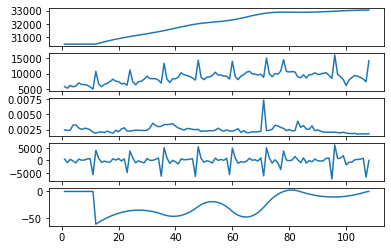

In [22]:
fig,ax = plt.subplots(nrows=5,sharex=False,sharey=False)
ax[0].plot(np.arange(1,109),x1_alcohol)
ax[1].plot(np.arange(1,109),x2_crime)
ax[2].plot(np.arange(1,109),x3_tweet)
ax[3].plot(np.arange(1,109),x4_shifted_crime)
ax[4].plot(np.arange(1,109),x5_shifted_alcohol)

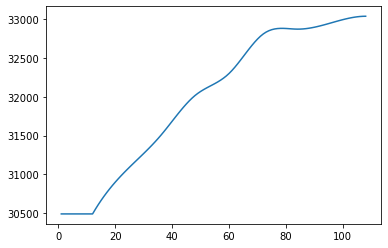

In [8]:
plt.plot(np.arange(1,109),x1_alcohol)
plt.savefig('./figures/alcohol.png')

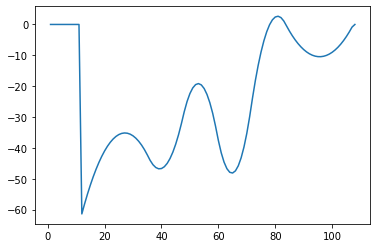

In [9]:
plt.plot(np.arange(1,109),x5_shifted_alcohol)
plt.savefig('./figures/shifted_alcohol.png')

In [23]:
corr = merged_data10.corr() #reference correlation
corr

,Number of establishments (ESTAB),actual_rape_total,cost_of_living_index,misogyny_proportion,shifted_rape_total,shifted_alcohol
Number of establishments (ESTAB),1.000000,0.588167,-0.570360,-0.077397,-0.004886,0.348424
actual_rape_total,0.588167,1.000000,-0.159612,-0.057513,0.540797,0.034345
cost_of_living_index,-0.570360,-0.159612,1.000000,0.288777,0.022099,-0.471996
misogyny_proportion,-0.077397,-0.057513,0.288777,1.000000,-0.178958,-0.039464
shifted_rape_total,-0.004886,0.540797,0.022099,-0.178958,1.000000,-0.062294
shifted_alcohol,0.348424,0.034345,-0.471996,-0.039464,-0.062294,1.000000


## i). Alcohol vs Crime

## 1. Calculate Mutual information

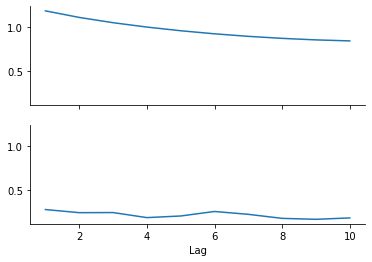

In [253]:
e1 = ccm.Embed(x1_alcohol)
e2 = ccm.Embed(x2_crime)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

## 2. Embed the time series

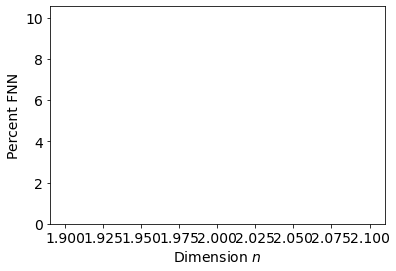

FNN embedding Dimension:  2


In [255]:
min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
min_index1 = max(min_index1, 1)
min_index2 = max(min_index2, 1)
lag = max(min_index1, min_index2)
print(lag)

perc_FNN, embed = FNN_n(x2_crime, lag, plotting = True)
print('FNN embedding Dimension: ',embed)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

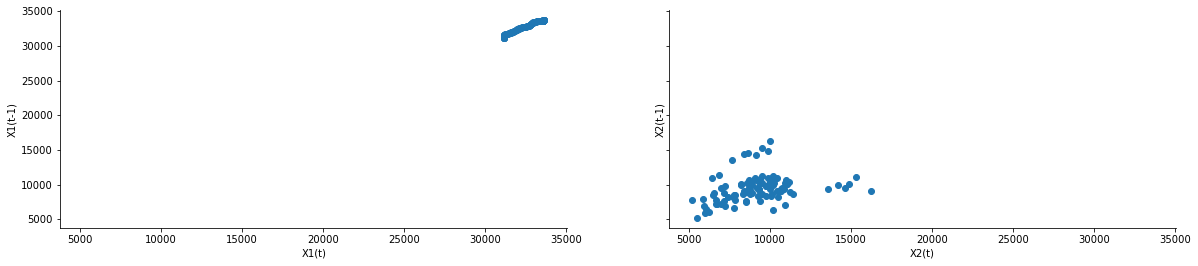

In [256]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(20,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

## 3. Forecast skill as a function of library length

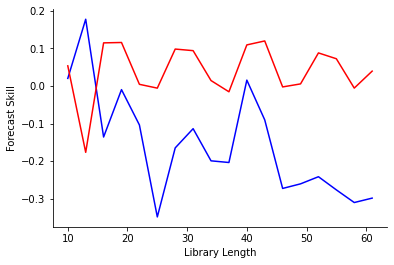

In [259]:
#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

# plot
fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # alcohol predict crime
ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict alcohol
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()

## ii). Shifted Alcohol vs Shifted Crime

## 1. Calculate Mutual information

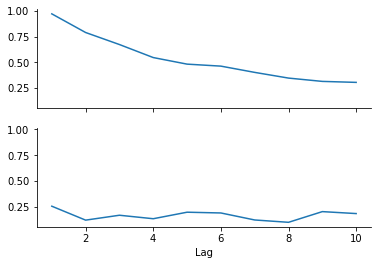

In [322]:
e1 = ccm.Embed(x5_shifted_alcohol)
e2 = ccm.Embed(x4_shifted_crime)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

## 2. Embed the time series

9


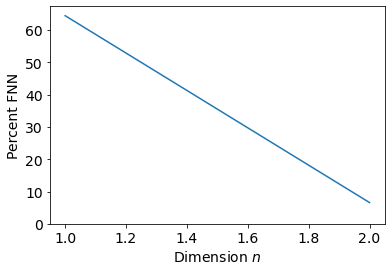

FNN embedding Dimension:  2


In [323]:
min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
min_index1 = max(min_index1, 1)
min_index2 = max(min_index2, 1)
lag = max(min_index1, min_index2)
print(lag)

perc_FNN, embed = FNN_n(x4_shifted_crime, lag, plotting = True)
print('FNN embedding Dimension: ',embed)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

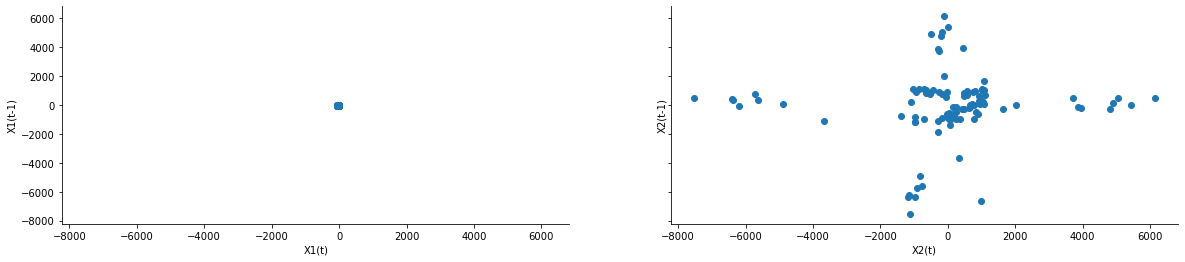

In [324]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(20,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

## 3. Forecast skill as a function of library length

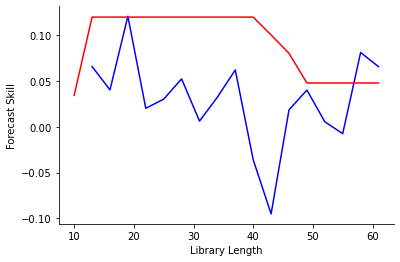

In [325]:
#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

# plot
fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # shifted alcohol predict shifted crime
ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # shifted crime predict shifted alcohol
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()

## iii). Shifted Alcohol vs Tweets

## 1. Calculate Mutual information

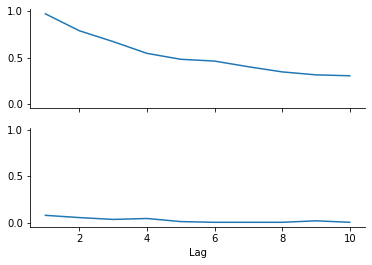

In [326]:
e1 = ccm.Embed(x5_shifted_alcohol)
e2 = ccm.Embed(x3_tweet)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

## 2. Embed the time series

9


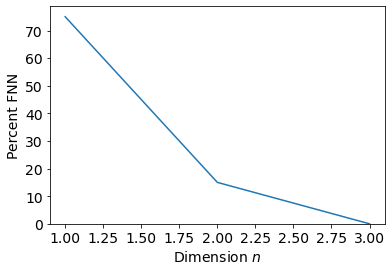

FNN embedding Dimension:  3


In [327]:
min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
min_index1 = max(min_index1, 1)
min_index2 = max(min_index2, 1)
lag = max(min_index1, min_index2)
print(lag)

perc_FNN, embed = FNN_n(x3_tweet, lag, plotting = True)
print('FNN embedding Dimension: ',embed)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

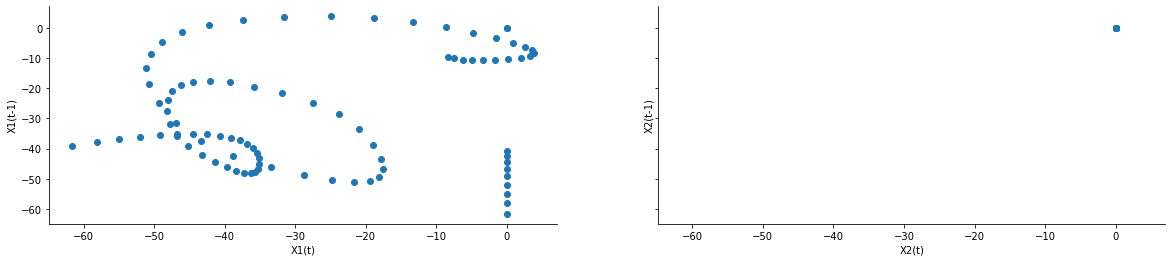

In [328]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(20,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

## 3. Forecast skill as a function of library length

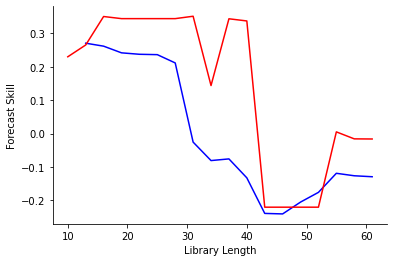

In [329]:
#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

# plot
fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # Shifted alcohol predict tweets
ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # tweets predict shifted alcohol
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()